In [1]:
suppressMessages(library(car))
suppressMessages(library(effects))
suppressMessages(library(emmeans))

data(mtcars)

# Origin factor
mtcars$origin <- c('Japan','Japan','USA','USA','USA','USA','USA','Europe','Europe',
                   'Europe','Europe','Europe','Europe','Europe','USA','USA','USA',
                   'Europe','Japan','Japan','Japan','USA','USA','USA','USA',
                   'Europe','Europe','Europe','USA','Europe','Europe','Europe')
mtcars$origin <- as.factor(mtcars$origin)

# VS factor
vs.lab <- rep("",length(mtcars$vs)) 
vs.lab[mtcars$vs == 0] <- "V-shaped"
vs.lab[mtcars$vs == 1] <- "Straight"
mtcars$vs <- as.factor(vs.lab)

# Create fake interaction
mpg.fake          <- mtcars$mpg                  # copy mpg
mpg.idx           <- mtcars$origin == "Japan" &
                     mtcars$vs     == "V-shaped" # index of Japan-VShaped cell
mpg.fake[mpg.idx] <- mpg.fake[mpg.idx] + 15      # add constant to all data from that cell
mtcars$mpg.fake   <- mpg.fake   

mod <- lm(mpg.fake ~ origin + vs + origin:vs, data=mtcars)

# Advanced Uses of `emmeans`


## Multiple Comparison Correction


### Familywise Error
Remembering back to our original justification for omnibus tests, we stated that the reason given is often one of error control. This perspective is much more in the Neyman-Pearson tradition than it is in the Fisherian tradition. The notion of the familywise error (FWER) is couched in Neyman-Pearson decision making and how often we would reach a false-positive conclusion over repeated tests. Fisher did not deny that calculating many $p$-values increased the chance of seeing small $p$-values. If you do something enough times, rare events will happen. However, he advocated for context and the use of the actual magnitude of the $p$-value to guide interpretation. In contrast, Neyman-Pearson wanted strict error control at a given $\alpha$-level. To briefly review, you can calculate the probability of false-positive decisions as

$$
\text{FWER} = 1 - (1 - \alpha)^{m},
$$

where $m$ is the number of tests being performed in the "family". For instance, if we only perform one test at $\alpha = 0.05$, we have

$$
\text{FWER} = 1 - (1 - 0.05)^{1} = 0.05.
$$

However, if we perform 100 tests we have

$$
\text{FWER} = 1 - (1 - 0.05)^{100} = 1 - 0.006 = 0.994.
$$

So we go from only a 5% probability of one or more false-positive under the null to a 99.4% probability of one or more false-positive under the null. As such, using a strict decision rule with a  fixed $\alpha$ only works to control the error-rate when we perform a single test. As soon as we start performing multiple tests, this error rate increases because the chance of seeing a rare event also increases. It is like buying millions of lottery tickets. The chance of any single ticket winning is very low, but if we buy enough of them we can almost guarantee that *at least one* of the tickets will be a winner. We are simply providing *more opportunities* for a rare event to occur.

Fisher acknowledged this situation, but he rejected the idea of fixing the error-rate *a priori*. Indeed, he said

```{epigraph}
...the calculation is absurdly academic, for in fact no scientific worker has a fixed level of significance at which from year to year, and in all circumstances, he rejects hypotheses; he rather gives his mind to each particular case in the light of his evidence and his ideas.

-- Fisher (Statistical Methods and Scientific Inference, 1956, p.42-45)
```

So Fisher would tell us to interpret the $p$-values in context. We do not choose a single $\alpha$ and then stick dogmatically to it in all circumstances. Rather, our marker for "significance" must be context-bound and relative to the problem at hand.

However, in our modern mish-mash of NHST, it is more typical to do exactly what Fisher did *not* want and fix $\alpha = 0.05$ in all circumstances, adjusting the results of tests to try and maintain this level irrespective of context. This is a deeply Nyman-Pearson idea, though we typically apply such corrections to Fisher's $p$-values rather than adjusting the critical value of the test.


### $p$-value Corrections in `R`

General access to $p$-values corrections is available in base `R` using the `p.adjust()` function. We simply supply a list of $p$-values and the name of the method we want to use and `R` will return the adjusted values. For instance

In [2]:
p.raw <- c(0.002, 0.765, 0.05, 0.123)
p.adj <- p.adjust(p=p.raw, method="bonferroni")

print(p.adj)

[1] 0.008 1.000 0.200 0.492


In this example, the basic Bonferroni method is used where each $p$-value is multiplied by the total number of $p$-values. We can see this for ourseleves by calculating this correction manually.

In [3]:
# bonferroni correction
n.p   <- length(p.raw)
p.adj <- p.raw * n.p 

# make sure all p <= 1
p.adj[p.adj > 1] <- 1

print(p.adj)

[1] 0.008 1.000 0.200 0.492


In terms of other adjustment methods, `R` has 6 built-in possibilities that can be listed by calling `p.adjust.methods`

In [4]:
print(p.adjust.methods)

[1] "holm"       "hochberg"   "hommel"     "bonferroni" "BH"        
[6] "BY"         "fdr"        "none"      


noting that `fdr` is an alias for `BH`, and `none` is just a pass-through option that does nothing. It is somewhat beyond this lesson to go into the details of all of these. A general heuristic is to use the `holm` method as the most general-purpose approach. This is more powerful than `bonferroni`, but has no additional assumptions. If the $p$-values are *correlated* (e.g. from repeated measurements), then `hochberg` is a better choice because it relaxes the assumption of independance, yet retains good power. If you have *a lot* of $p$-values (in the hundreds or thousands), then controlling the `fdr` is a more sensitive approach than controlling the FWER. For instance, FDR is a common method used in neuroimaging where the number of simultaneous tests across the brain can be in the hundreds of thousands.  

### Corrections in `emmeans` and Families of Tests
In terms of using these corrections within `emmeans`, it is a simple as using the `adjust` argument to name the correction that we want applied. As an example, using the `holm` method with the follow-up tests of the `vs:origin` interaction gives.

In [5]:
emm <- emmeans(mod, pairwise ~ vs|origin, adjust="holm")
print(emm$contrasts)

origin = Europe:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.20 2.24 26   2.765  0.0103

origin = Japan:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)    -7.40 3.79 26  -1.954  0.0616

origin = USA:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.02 2.73 26   2.203  0.0367



Now, you would be forgiven for thinking that nothing has changed here. And, in fact, you would be right. In this instance, `emmeans` has not applied any correction, despite our request. So what is going on?

The answer lies in the concept of a *family* of tests. Note from the definition of FWER that $m$ was the number of tests *in the family*. Similarly, the name FWER literally indicates that the error rate is defined *familywise*. So what is a family? Simply put, it is a collection of tests that we choose to treat as a single unit with a similar inferential goal. So, there is no formal of mathematical definition here. The family is whatever we choose it to be for the purpose of Type I error control.

Within `emmeans`, a family is defined by whatever factor we place on the right-hand side of the `|` symbol. In the example above, we place `origin` here so that the effect of `vs` was evaluated at each level of `origin`. Each level of `origin` therefore forms a *family* of tests with a common inferential goal and any correction is applied within each family separately. Because the `vs` factor only has two levels only a single test is performed within each family and no correction is applied. However, if we define the interaction tests the other way around, so that the levels of `vs` form the families, we can see that the correction *is* applied.

In [6]:
emm <- emmeans(mod, pairwise ~ origin|vs, adjust="holm")
print(emm$contrasts)

vs = Straight:
 contrast       estimate   SE df t.ratio p.value
 Europe - Japan    -4.14 2.81 26  -1.473  0.3056
 Europe - USA       3.70 2.81 26   1.316  0.3056
 Japan - USA        7.83 3.39 26   2.312  0.0869

vs = V-shaped:
 contrast       estimate   SE df t.ratio p.value
 Europe - Japan   -17.73 3.39 26  -5.234  <.0001
 Europe - USA       3.52 2.14 26   1.641  0.1128
 Japan - USA       21.25 3.21 26   6.611  <.0001

P value adjustment: holm method for 3 tests 


```{admonition} Post-hoc Tests and Planned Comparisons
:class: tip
In general, any test performed in an effort to unpack the ANOVA omnibus test is regarded as a *follow-up test*, because it follows the main ANOVA analysis. However, a distinction is sometimes made related to the *intent* behind the tests. Sometimes, follow-up tests are known as *post-hoc tests* when we have found a significant effect and then wish to break it down. Other times, follow-up tests are known as *planned comparisons* when we decided on the comparisons we wanted to make *before* running the analysis, irrespective of the omnibus results. This distinction is really between whether we wish to be guided by the omnibus tests and then exhaustively search the results to discover what the omnibus test is trying to tell us, versus deciding on a few choice comparisons before the analysis and then just sticking to those and not looking at anything else. *Post-hoc* tests are quite common in Psychology and Cognitive Neuroscience, whereas *planned comparisons* may be more relevant for something like a clinical trial where the only differences we care about are those between the patients and controls. 

The point of bringing this up is that arguments are sometimes made around error-control and the type of follow-up test we are using. For instance, it is common to hear that multiple comparisons corrections are only needed with post-hoc tests, but not with planned comparisons. This indicates that if you decide on your comparisons beforehand, you do not need to perform any sort of $p$-value correction. *Beware of this reasoning*. Although planned comparisons are more *credible* in the sense that you are not $p$-hacking, this does not change anything about the error rate. The error does not magically know what your intentions were and then change itself. The error rate is a fact of multiple testing that does not change with intent. As such, even if you have pre-specified tests, you still need to control for multiple comparisons. *Our intentions do not change the laws of probability*.
```

## Effect Sizes and Confidence Intervals
Given that all our inference so far has relied on NHST, it is useful to know how we could produce something more in-line with the ideas of the New Statistics, focusing on *estimation* and *precision*, rather than hypothesis testing. To that end, we will breifly discuss effect sizes, confidence intervals and how they can be generated.

### Effect Sizes from Omnibus Tests
As a first topic, we might want to simply replace our inferential device for all elements of our ANOVA analysis to one aligned with *estimation* rather than NHST. So, our starting point is the omnibus tests. There are a myriad of effect sizes available to use for the omnibus tests ($\eta^{2}, \text{partial}-\eta^{2}, \omega^{2}$, etc.), but perhaps the easiest to intepret is Cohen's $f^{2}$. This is defined in terms of the $R^{2}$ from the the null and full models, so has a direct connection with the ANOVA as a model comparisons procedure. The formula is given by

$$
f^{2} = \frac{R^{2}_{\text{full}} - R^{2}_{\text{null}}}{1 - R^{2}_{full}}.
$$

Remembering that $R^{2}$ gives the proportion of variance explained by the model, $f^{2}$ tells us how large the change in variance explained is, relative to how much variance is still left over. The bigger $f^{2}$ is, the more variance the full model has explained, relative to how much still remains to be explained. The square-root is also taken sometimes to give Cohen's $f$, which is the same matric but expressed in units of *standard deviation*.

To calculate this in `R`, we can make use of the `effectsize` package

In [7]:
library(effectsize)
anova.table <- Anova(mod)
effect.size <- cohens_f(anova.table)
print(effect.size)

# Effect Size for ANOVA (Type II)

Parameter | Cohen's f (partial) |      95% CI
---------------------------------------------
origin    |                1.22 | [0.76, Inf]
vs        |                0.47 | [0.12, Inf]
origin:vs |                0.64 | [0.22, Inf]

- One-sided CIs: upper bound fixed at [Inf].

So how do we interpret this? One approach is to use Cohen's own cutoffs of ... However, this is controversial because these values are somewhat arbitrary and realistically cannot be universally applicable in all situations. In addition, if all we are doing is determining how meaningful effects are based on arbitrary cut-offs, we are not doing much better than NHST with $\alpha = 0.05$. The more *New Statistics* way is to interpret each effect on its own in relation to its mangitude and precision. For instance, we can see that `origin` has the largest effect, followed by `origin:vs` and then `vs` alone. Focusing on the interaction, $f^2 = 0.64^2 = 0.41$. So, the interaction's contribution to the model is 41% as large as the residual variance of the full model. This feels a bit wonky to interpret, but we need to think of the residual variance of the full model as our *noise floor*. For this model, we cannot make the noise any smaller than this value. As such, this is our benchmark by which we judge the variance reduced by a given predictor. However, this still does not feel particularly *intuitive*. The problem is that *all* omnibus effect sizes are a compromise because an omnibus effect is a *pattern* not a *quantity*. In trying to reduce this to a single number, we run into difficulties because, funamentally, an omnibus test is not related to any practical effect we are actually interested in. In a way, this idea of an "overall effect" is not really of much use to us and is difficult to define in any coherent way that relates to the actual differences in the data that we care about.
   
On this basis, it is not often worth worrying about effect sizes on omnibus tests. Indeed, from the perspective of *estimation*, omnibus tests are not really of any interest. If we take them as a form of error-control, then this is no longer relevant because we are only interested in effects and their precision, not long-run decision making. If we take them as a form of time-saving screening, this is largely unnecessary in the modern world because computers can create all the comparisons we want instantaneously. The only legitimate argument in their favour is the idea that omnibus tests can serve as an *optional noise filter*, giving you a quick global check on whether a factor has any signal worth interpreting before diving into multiple individual effects. This is more coherently expressed in the idea of finding the *best model* for the data before interpreting the effects and so will depend upon what metric is used to define "best" in this scenario. Indeed, we can simply replace the idea of omnibus tests with the idea of *model building* and then interpret the individual comparisons once we have a model we are happy with. This is a much more modern and coherent perspective than omnibus ANOVA tests. We will see more about model comparisons and model building in the Machine Learning module next semester.

### Effect Sizes from `emmeans`
The much more interpretable application of effect sizes comes directly from the individual comparisons of means. This is where we can use Cohen's $d$ as an easily interpretable standardised mean difference on the scale of the standard deviation. This can be calculated directly using the `eff_size()` function from `emmeans`. For instance 

In [8]:
emm <- emmeans(mod, ~ vs|origin)
eff <- eff_size(emm, sigma=sigma(mod), edf=df.residual(mod))

print(eff)

origin = Europe:
 contrast              effect.size    SE df lower.CL upper.CL
 Straight - (V-shaped)        1.49 0.578 26   0.3042    2.682

origin = Japan:
 contrast              effect.size    SE df lower.CL upper.CL
 Straight - (V-shaped)       -1.78 0.946 26  -3.7274    0.161

origin = USA:
 contrast              effect.size    SE df lower.CL upper.CL
 Straight - (V-shaped)        1.45 0.688 26   0.0351    2.865

sigma used for effect sizes: 4.15 
Confidence level used: 0.95 


Here we can see each of the comparisons between `Straight` and `V-shaped` engines expressed in standard deviation units. In general, each of these effects represents a change of around 1.5 standard deviations in MPG. We can think of this as a mean shift between two standard normal distributions. This is illustrated in the plot below and gives some visual intuition behind what Cohen's $d$ is telling us.

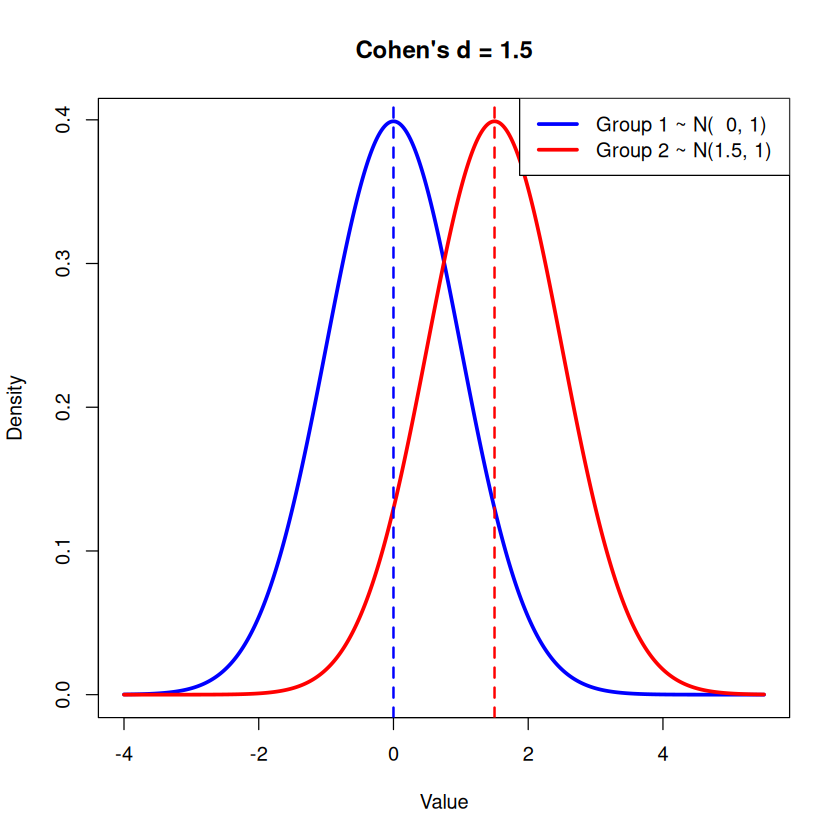

In [60]:
#========================================================================================#
# Use this function to visualise any value of Cohen's d
#========================================================================================#
plot.cohens.d <- function(d){
    # Sequence of x values covering both distributions
    if (d < 0){
        x <- seq(-4+d, 4,   length.out=1000)
    } else {
        x <- seq(-4,   4+d, length.out=1000)
    }

    # Standard normal
    y1 <- dnorm(x, mean=0, sd=1)

    # Shifted normal
    y2 <- dnorm(x, mean=d, sd=1)

    # Plot
    plot(x, y1, type="l", lwd=3, col="blue", xlab="Value", ylab="Density",
        main=paste0("Cohen's d = ",d))

    lines(x, y2, lwd=3, col="red")

    # Add vertical lines at the means
    abline(v=0, lwd=2, col="blue", lty=2)
    abline(v=d, lwd=2, col="red",  lty=2)

    legend("topright", legend=c("Group 1 ~ N(  0, 1)", paste0("Group 2 ~ N(",d,", 1)")),
           col=c("blue","red"), lwd=3)
}

plot.cohens.d(1.5)


So, in all cases, this is potentially an interesting effect. However, we also need to consider the precision. For he `Europe` comparison, the 95% CI is $[0.30,2.68]$, which is reasonably uncertain. It suggests that the true effect could be as small as $d=0.3$ (a tiny mean shift) or as large as $d=2.68$ (quite a large mean shift). So whilst this is at least indicative of a *positive* effect, its exact magnitude remains a bit uncertain. Similarly, the 95% CI for `USA` is $[0.04,2.87]$, which is even wider and thus even more uncertain. Finally, the interval for `Japan` is $[-3.73,0.16]$, which is even more uncertain, especially as it includes both 0 and a reversal of the direction of the effect. So, based on this, we are most confident about the estimate for `Europe`, less so about the estimate for `USA` and even less so about the estimate for `Japan`. 

## Type II Follow-up Tests
... If we go back to our original (non-fake) data where there is no 2-way interaction, ...

## Higher-order Interactions


Although we have now seen how to follow-up a 2-way interaction with `emmeans`, things get more complex when we have even higher-order interactions in the model. In general, it is not recommended to go beyond a 3-way interaction due to the complexities that come with interpretation. You can, if you wish, but things start getting difficult very quickly. Here, we will demonstrate using `emmeans` to break-down a 3-way interaction.

In order to do so, we will be using a different dataset. Within the `datarium` package there is a dataset called `headache` that gives results from a clinical trial of 3 treatments for headaches. The factors available are `gender`, `risk` and `treatment`. The outcome variable is `pain_score`.

In [9]:
library('datarium')
data(headache)
print(head(headache))

# A data frame: 6 × 5
     id gender risk  treatment pain_score
* <int> <fct>  <fct> <fct>          <dbl>
1     1 male   low   X               79.3
2     2 male   low   X               76.8
3     3 male   low   X               70.8
4     4 male   low   X               81.2
5     5 male   low   X               75.1
6     6 male   low   X               73.1


We can proceed using our usual approach, though we will skip the call to `summary()` and the checking of assumptions, in the interests of saving space.

In [10]:
mod <- lm(pain_score ~ gender*risk*treatment, data=headache)
print(Anova(mod))

Anova Table (Type II tests)

Response: pain_score
                       Sum Sq Df F value    Pr(>F)    
gender                 313.36  1 16.1957 0.0001625 ***
risk                  1793.56  1 92.6988   8.8e-14 ***
treatment              283.17  2  7.3177 0.0014328 ** 
gender:risk              2.73  1  0.1411 0.7084867    
gender:treatment       129.18  2  3.3384 0.0422001 *  
risk:treatment          27.60  2  0.7131 0.4942214    
gender:risk:treatment  286.60  2  7.4063 0.0013345 ** 
Residuals             1160.89 60                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


So we can see that there is a significant 3-way interaction. How do we follow this up? We could adapt the `pairwise ~` syntax we used earlier to give

In [11]:
emm <- emmeans(mod, pairwise ~ gender:risk|treatment)
print(emm$contrasts)

treatment = X:
 contrast                 estimate   SE df t.ratio p.value
 male high - female high     13.87 2.54 60   5.463  <.0001
 male high - male low        16.69 2.54 60   6.571  <.0001
 male high - female low      18.58 2.54 60   7.317  <.0001
 female high - male low       2.81 2.54 60   1.108  0.6862
 female high - female low     4.71 2.54 60   1.854  0.2588
 male low - female low        1.90 2.54 60   0.746  0.8778

treatment = Y:
 contrast                 estimate   SE df t.ratio p.value
 male high - female high      1.17 2.54 60   0.459  0.9676
 male high - male low         9.20 2.54 60   3.624  0.0033
 male high - female low      13.98 2.54 60   5.505  <.0001
 female high - male low       8.04 2.54 60   3.165  0.0127
 female high - female low    12.81 2.54 60   5.045  <.0001
 male low - female low        4.78 2.54 60   1.881  0.2471

treatment = Z:
 contrast                 estimate   SE df t.ratio p.value
 male high - female high     -1.35 2.54 60  -0.533  0.9506
 male hig

However, the problem here is that the `gender` and `risk` factors have been collapsed, leading to some comparisons that keep one factor constant (e.g. `male high - female high`) whereas others that change both factors (e.g. `male high - female low`).

A better approach is to get `emmeans` to more sensibly combine the levels of the various factors. One approach is to simply generate all the means and then use the `contrast()` function with the `interaction` and `by` options. For instance

In [12]:
emm <- emmeans(mod, ~ gender*risk*treatment)
contrast(emm, interaction=c(gender="pairwise", risk="pairwise"), by="treatment")

treatment = X:
 gender_pairwise risk_pairwise estimate   SE df t.ratio p.value
 male - female   high - low       11.98 3.59 60   3.335  0.0015

treatment = Y:
 gender_pairwise risk_pairwise estimate   SE df t.ratio p.value
 male - female   high - low       -3.61 3.59 60  -1.005  0.3188

treatment = Z:
 gender_pairwise risk_pairwise estimate   SE df t.ratio p.value
 male - female   high - low       -6.03 3.59 60  -1.679  0.0983


This has effectively given us 3 interaction tests, one for each level of treatment. So we can conclude that there is a significant interaction effect between `gender` and `risk`, but only for treatment `X`. We could investigate this further by holding one of the factors in the `interaction` option constant by setting its contrasts to `"identity"`. For example

In [61]:
contrast(emm, interaction=c(gender="pairwise", risk="identity"), by="treatment", adjust="holm")

treatment = X:
 gender_pairwise risk_identity estimate   SE df t.ratio p.value
 male - female   high             13.87 2.54 60   5.463  <.0001
 male - female   low               1.90 2.54 60   0.746  0.4583

treatment = Y:
 gender_pairwise risk_identity estimate   SE df t.ratio p.value
 male - female   high              1.17 2.54 60   0.459  0.6477
 male - female   low               4.78 2.54 60   1.881  0.1297

treatment = Z:
 gender_pairwise risk_identity estimate   SE df t.ratio p.value
 male - female   high             -1.35 2.54 60  -0.533  0.5958
 male - female   low               4.68 2.54 60   1.841  0.1410

P value adjustment: holm method for 2 tests 

So we can see that the `gender` effect for treatment `X` is only within the `high` risk group and not the `low` risk group. There are marginal effect of `gender` for the other treatments, but we need to be careful interpreting these if the interaction effects were not significant. In addition, these effects may not survive multiple comparisons correction, as we will see in the next section.

[^fake-foot]: Remember, these data are *entirely* fabricated. There is nothing magical about Japanese cars that makes V-shaped engines super efficient in terms of MPG.

[^modmat-foot]: You do not need to construct these weights manually, as shown in the code. Instead, you can get the coding for the *whole* model by using the `model.matrix()` function and passing in the model object. This will show you the *exact* coding for every data point in the model.

[^cohen-foot]: Cohen's aim was to get practitioners away from $p$-values and the dichotomisation of evidence. So, instead, he decided to *trichotomise* his measure of effect size into *Small = 0.2*, *Medium = 0.5* and *Large = 0.8*. In Cohen's defence, this was likely a compromise position to try and get his effect size adopted by researchers who do not like subtlety and nuance in their results and would rather just have rules to follow. This is something you will come up against time and time again in the wider world of research.

[^neg-foot]: The fact that this is `-1` rather than `1` makes no differences. It just reverses the direction of the comparison.

[^followup-foot]: This is the approach often advocated in Psychology to follow-up an ANOVA, but it is far from the most appropriate.

[^bonf-foot]: Bonferroni is a very common correction where each $p$-value is multiplied by the number of tests.

[^interact-foot]: Alternatively, we can think of this as indicating that the differences in MPG betwee `Japan`, `USA` and `Europe` depends upon whether the engine is `Straight` or `V-Shaped`. Although interactions can be interpreted different ways around, for most problems there is usually one way of conceptualising the interaction that is more intuitive or useful than the other.

[^regmc-foot]: Though we should be aware that the regression tests are not corrected for multiple comparisons.